<a href="https://colab.research.google.com/github/dheerajreddy2020/OpenCV_Yolo_Object_detection_tracking/blob/master/Yolo_predict_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Upgrade the opencv to the latest
* Make sure you have cv2 version higher than 4.5

In [1]:
!pip install --upgrade opencv-python

Requirement already up-to-date: opencv-python in /usr/local/lib/python3.7/dist-packages (4.5.1.48)


In [1]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
cv2.__version__

'4.5.1'

## Clone the github Repo

In [2]:
import shutil
dir_path = 'object_detection'
shutil.rmtree(dir_path)
#dir_path.rmdir()

In [2]:
import os
base_dir = os.getcwd()
!git clone https://github.com/dheerajreddy2020/OpenCV_Yolo_Object_detection_tracking.git 'object_detection'

fatal: destination path 'object_detection' already exists and is not an empty directory.


In [3]:
os.chdir(base_dir)
os.chdir('object_detection')
# save the location for future reference
yolo_dir = os.getcwd()

## Download the Yolo configuration files

In [5]:
!wget -O yolov3.cfg https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
!wget -O yolov3.weights https://pjreddie.com/media/files/yolov3.weights
!wget -O coco.names https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names

--2021-02-28 18:30:43--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8342 (8.1K) [text/plain]
Saving to: ‘yolov3.cfg’

yolov3.cfg          100%[===================>]   8.15K  --.-KB/s    in 0s      

2021-02-28 18:30:43 (67.7 MB/s) - ‘yolov3.cfg’ saved [8342/8342]

--2021-02-28 18:30:43--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  20.2MB/s    in 12s     

2021-02-28 18

In [4]:
from processing_functions import *

* Image reference : Image downloaded from flickr 8k dataset

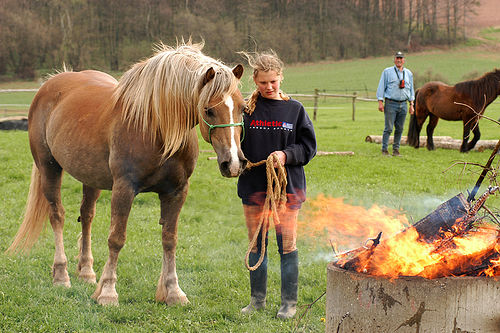

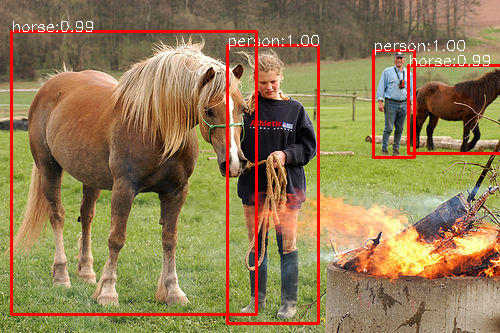

In [5]:
# Convert the image into numpy array
img = cv2.imread('test_image.jpg')
# Show the original image
cv2_imshow(img)

# Initialize the Yolo
net,classes = yolo_init()
# Run the Yolo network on the image
outs = yolo_predict_image(img,net)

confThreshold = 0.5  #Confidence threshold
nmsThreshold = 0.4   #Non-maximum suppression threshold

# Post process the outputs and display on image
image = postprocess(img, outs,confThreshold,nmsThreshold, classes)
# Show the predicted image
cv2_imshow(image)

In [6]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Downloading a youtube video to predict

In [20]:
!pip install pytube

     |████████████████████████████████| 51kB 5.6MB/s 


### Mount the google drive to save the video from youtube

In [7]:
from google.colab import drive
# Mount your google drive
drive.mount('/content/drive/')
# Give the path to the folder in which videos are located, or you want to download
os.chdir('/content/drive/MyDrive/Computer_Vision_Project/OpenCV_yolo')
# Save the video file directory
video_file_dir = os.getcwd()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import pytube
# url to download the video from youtube
url = 'https://www.youtube.com/watch?v=eCQoTgxCCSg&ab_channel=bitgood'
youtube = pytube.YouTube(url)
video = youtube.streams.first()
# Download the video
video.download()

In [15]:
# Check the video file name and input it into a variable
filename = 'UK Road traffic M27 HD both ways rush hour vehicles motorway  highway.mp4'
floc = os.path.join(video_file_dir,filename)
# Define the location of predicted video
prediction_loc = os.path.join(video_file_dir,'predicted_video.avi')
# Change the working directory back to yolo folder
os.chdir(yolo_dir)

## Predictions on a video

### Using mask function to define the region of interest
* This is useful to select the region of interest in the video frame, where the predictions have to be done

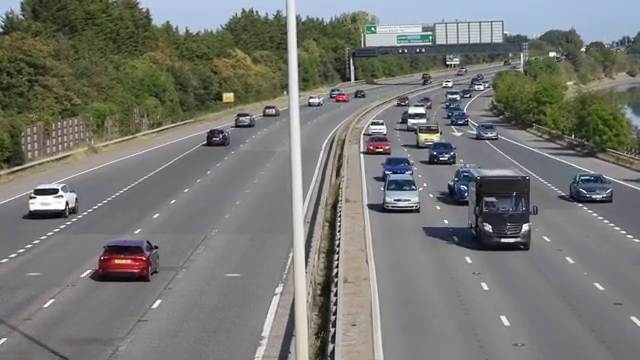

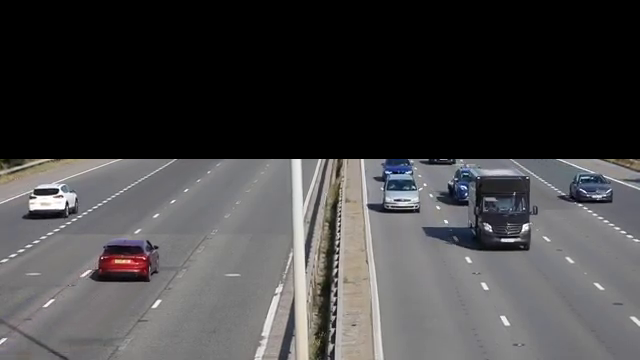

In [11]:
REFPT = [[0, 80], [638, 80], [639, 359], [0, 358]]
# testing the mask_function
cap = cv2.VideoCapture(floc)
cap.set(1, 50)
ret, frame = cap.read()
cv2_imshow(frame)
img = mask_image(frame,REFPT)
cv2_imshow(img)

### Reading frames from video and writing it to number array

In [9]:
%%time
REFPT = [[0, 80], [638, 80], [639, 359], [0, 358]]
# define the batch size to start predictions
# Define the nummber of frames you want to skip
skip = 2
# set the mask to the reference points to define the region of interest
imgs,frames = images_array(floc,time_in_mins = 3,skip=skip, mask = REFPT)


CPU times: user 4min 3s, sys: 17 s, total: 4min 20s
Wall time: 1min 20s


### Initialize Yolo

In [10]:
# initialize Yolo
net,classes = yolo_init()

### Make predictions on the array of frames

In [11]:
BATCH_SIZE = 64  # Define Batch size for predictions
out_batches, batches, rem = predict_video(imgs,net,batch_size = BATCH_SIZE) # Pass the processed frames onto Yolo

### Post processing :
* Read the predictions and draw annotations on the frames
* Initiate the dictionaries to track and count the select classes.

In [12]:
# Initialize the count dictionary
# Set the Classes to track and count
count_north = {'car':0, 'bus': 0, 'truck': 0}
count_south = {'car':0, 'bus': 0, 'truck': 0}
count_dicts = [count_north, count_south]

# Set count_classes to the count_dicts if you want to count the objects detected in the video
out_frame_batches = output_frames(frames, out_batches, BATCH_SIZE, batches, rem, classes, count_classes = count_dicts)

### Video from the post-processed frames

In [17]:
video_loc = prediction_loc
cap = cv2.VideoCapture(floc)
fps = round(cap.get(cv2.CAP_PROP_FPS)/2)
create_video(out_frame_batches,video_loc,fps)

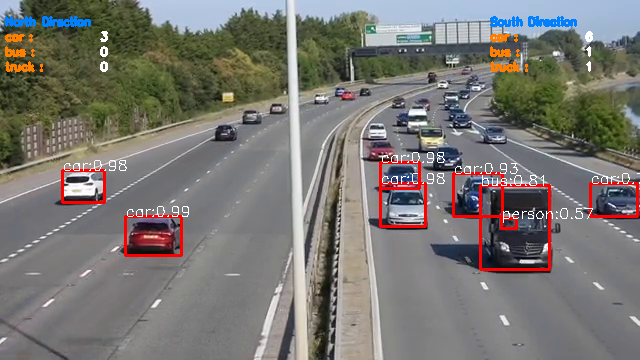

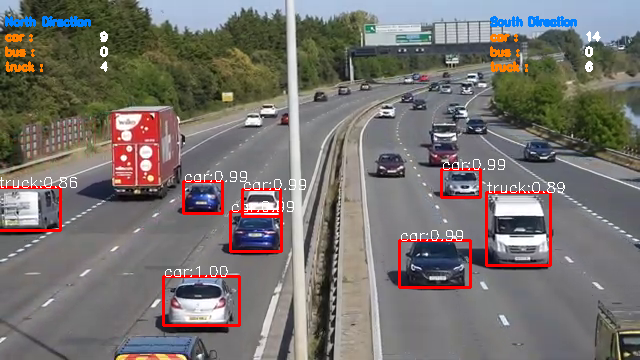

In [21]:
# Displaying random frames
cv2_imshow(out_frame_batches[0][30])
cv2_imshow(out_frame_batches[1][40])